# Variational autoencoder

The variational autoencoder should be able to identify abnormal heartbeat patterns.

In [2]:
from mads_datasets.base import BaseDatastreamer
from mltrainer.preprocessors import BasePreprocessor
import matplotlib.pyplot as plt
from pathlib import Path
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix
from torch import nn
import torch
import gin
from streamer import VAEstreamer
import rae_model
from loguru import logger
import numpy as np
import sys
import datasets, metrics
import mltrainer
from mltrainer import ReportTypes, Trainer, TrainerSettings


In [3]:

gin.parse_config_file('../src/rae_config.gin') #latent 24 hidden 40

# use the binary data for training the Variational Autoencoder
trainfileVAE = Path('../data/heart_train.parq').resolve()
testfileVAE = Path('../data/heart_test.parq').resolve()
validationfileVAE = Path('../data/heart_test.parq').resolve()

# Remove outliers for training the VAE
traindatasetVAE = datasets.HeartDataset1D(trainfileVAE, target="target", outliersRemoval=True)
testdatasetVAE = datasets.HeartDataset1D(testfileVAE, target="target", outliersRemoval=True)

#  Keep outliers for validation and finding a appropriate reconstructionloss
validsdatasetVAE = datasets.HeartDataset1D(testfileVAE, target="target", outliersRemoval=False)

trainstreamerVAE = VAEstreamer(traindatasetVAE, batchsize=32).stream()
teststreamerVAE = VAEstreamer(testdatasetVAE, batchsize=32).stream()
validstreamerVAE = VAEstreamer(testdatasetVAE, batchsize=32).stream()

Training the Autoencoder is really hard, because it could reconstruct a lot of abnormal samples with a reconstruction loss as small as with the normal samples.
Therefore some comparison is made

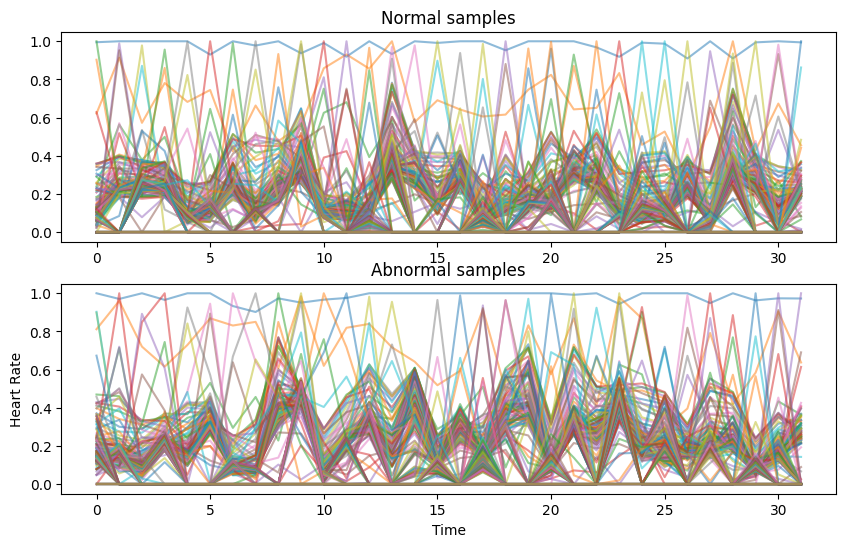

In [4]:
import matplotlib.pyplot as plt

# Initialize a plot
fig = plt.figure(figsize=(10, 6))

XN, X2 = next(trainstreamerVAE)
XA, X2 = next(validstreamerVAE)

XN = XN.view(XN.size(0), -1) 
XA = XA.view(XA.size(0), -1) 

ax1 = fig.add_subplot(2, 1, 1)
ax2 = fig.add_subplot(2, 1, 2)

ax1.plot(XN, alpha=0.5)
ax1.set_title('Normal samples')

ax2.plot(XA, alpha=0.5)
ax2.set_title('Abnormal samples')


plt.xlabel('Time')
plt.ylabel('Heart Rate')

# Show plot
plt.show()

In [8]:
X1, X2 = next(trainstreamerVAE)
#Best latent 40 hidden 50
hypertune_config = {
                    "num_layers" : 1,
                    "seq_len" : 192,
                    "latent" : 40,
                    "hidden" : 128,
                    "dropout" : 0.2,
                    "features" : 1,
                }

encoder = rae_model.Encoder(hypertune_config)
decoder = rae_model.Decoder(hypertune_config)

logger.info(f"the shape before : {X1.shape}")

latent = encoder(X1)
logger.info(f"the latent shape : {latent.shape}")

x = decoder(latent)
logger.info(f"the shape after: {x.shape}")

lossfn = rae_model.ReconstructionLoss()
loss = lossfn(x, X2)
logger.info(f"Untrained loss: {loss}")

logger.info(f"starting training for {200} epochs")



autoencoder = rae_model.RecurrentAutoencoder(hypertune_config,hypertune_config)

settings = TrainerSettings(
    epochs=200,
    metrics=[lossfn],
    logdir="logs",
    train_steps=200,
    valid_steps=200,
    reporttypes=[ReportTypes.TENSORBOARD],
    earlystop_kwargs = {
        "save": False,
        "verbose": True,
        "patience": 10,
    },
    optimizer_kwargs = {"lr": 1e-4},
    scheduler_kwargs={"factor": 0.1, "patience": 5},
)

trainer = Trainer(
    model=autoencoder,
    settings=settings,
    loss_fn=lossfn,
    optimizer=torch.optim.Adam,
    traindataloader=trainstreamerVAE,
    validdataloader=teststreamerVAE,
    scheduler=torch.optim.lr_scheduler.ReduceLROnPlateau,
)
trainer.loop()


2024-07-04 16:43:04.453 | INFO     | __main__:<module>:15 - the shape before : torch.Size([32, 192, 1])


2024-07-04 16:43:04.847 | INFO     | __main__:<module>:18 - the latent shape : torch.Size([32, 40])
2024-07-04 16:43:04.917 | INFO     | __main__:<module>:21 - the shape after: torch.Size([32, 192, 1])
2024-07-04 16:43:04.962 | INFO     | __main__:<module>:25 - Untrained loss: 7.771693706512451
2024-07-04 16:43:04.964 | INFO     | __main__:<module>:27 - starting training for 200 epochs
2024-07-04 16:43:04.980 | INFO     | mltrainer.trainer:dir_add_timestamp:29 - Logging to logs/20240704-164304
2024-07-04 16:43:05.612 | INFO     | mltrainer.trainer:__init__:72 - Found earlystop_kwargs in settings.Set to None if you dont want earlystopping.
100%|██████████| 200/200 [00:33<00:00,  5.96it/s]
2024-07-04 16:43:50.791 | INFO     | mltrainer.trainer:report:191 - Epoch 0 train 4.6912 test 2.6835 metric ['2.6835']
100%|██████████| 200/200 [00:32<00:00,  6.19it/s]
2024-07-04 16:44:34.833 | INFO     | mltrainer.trainer:report:191 - Epoch 1 train 2.5518 test 2.0802 metric ['2.0802']
100%|██████████

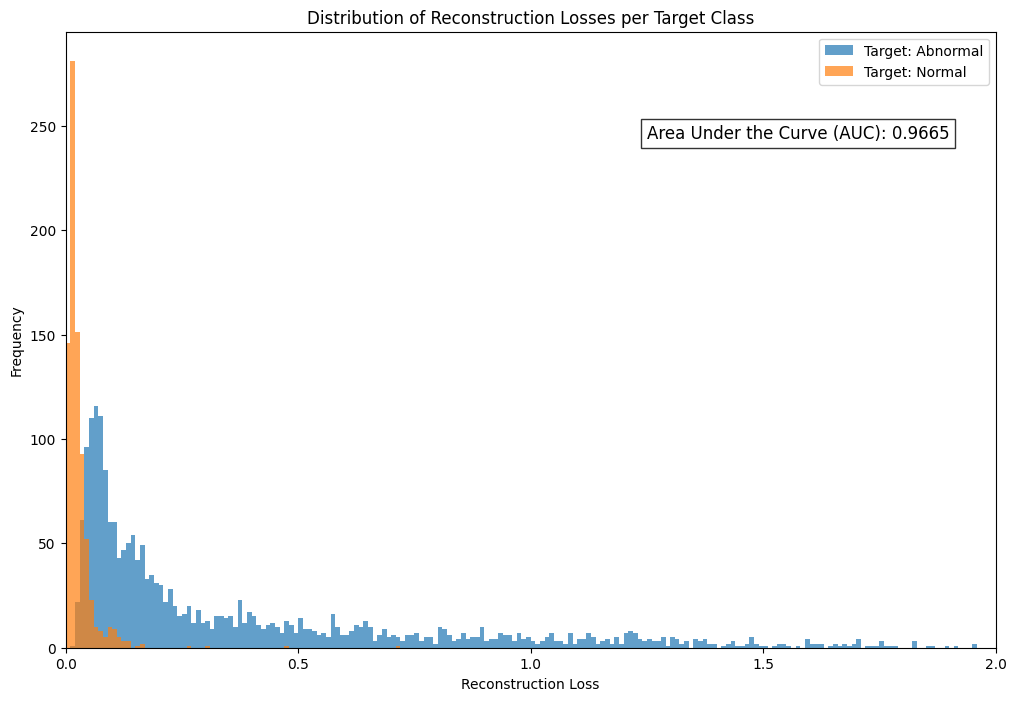

In [6]:
import random
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from sklearn.metrics import roc_auc_score

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def predict(autoencoder, dataset):
    predictions, losses = [], []
    criterion = rae_model.ReconstructionLoss()
    with torch.no_grad():
        autoencoder.eval()

        for input_sequence, target in dataset:
            input_sequence = input_sequence.unsqueeze(0).to(device) 

            seq_pred = autoencoder(input_sequence)
            loss = criterion(seq_pred, input_sequence.squeeze(0)) 
            
            predictions.append(seq_pred.cpu().numpy().flatten())
            losses.append(loss.item())
    return predictions, losses

def plot_losses_per_target(dataset, autoencoder):
    losses_per_target = {}

    _, all_losses = predict(autoencoder, dataset)
    for loss, (_, target) in zip(all_losses, dataset):
        target_class = "abnormal" if target.item() == 1 else "normal"
        if target_class not in losses_per_target:
            losses_per_target[target_class] = []
        losses_per_target[target_class].append(loss)

    normal_losses = losses_per_target['normal']
    abnormal_losses = losses_per_target['abnormal']
    
    all_losses_flat = normal_losses + abnormal_losses
    targets_flat = [0] * len(normal_losses) + [1] * len(abnormal_losses)
    
    auc_value = roc_auc_score(targets_flat, all_losses_flat)
    
    fig, ax = plt.subplots(figsize=(12, 8))
    for target_class, loss_list in losses_per_target.items():
        ax.hist(loss_list, bins=np.arange(0, 4, 0.01), alpha=0.7, label=f'Target: {target_class.capitalize()}')
    
    ax.set_xticks(np.arange(0, 4, 0.5))
    ax.set_xticklabels(np.arange(0, 4, 0.5))
    ax.set_xlabel('Reconstruction Loss')
    ax.set_ylabel('Frequency')
    ax.set_title('Distribution of Reconstruction Losses per Target Class')
    ax.legend()

    plt.xlim(0, 2)  
    plt.text(0.95, 0.85, f'Area Under the Curve (AUC): {auc_value:.4f}', transform=ax.transAxes,
             verticalalignment='top', horizontalalignment='right', fontsize=12, bbox=dict(facecolor='white', alpha=0.8))

    plt.show()

plot_losses_per_target(validsdatasetVAE, autoencoder)



/home/azureuser/code/nickyvanoorschot_mads_exam_24/.venv/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([192, 1])) that is different to the input size (torch.Size([1, 192, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


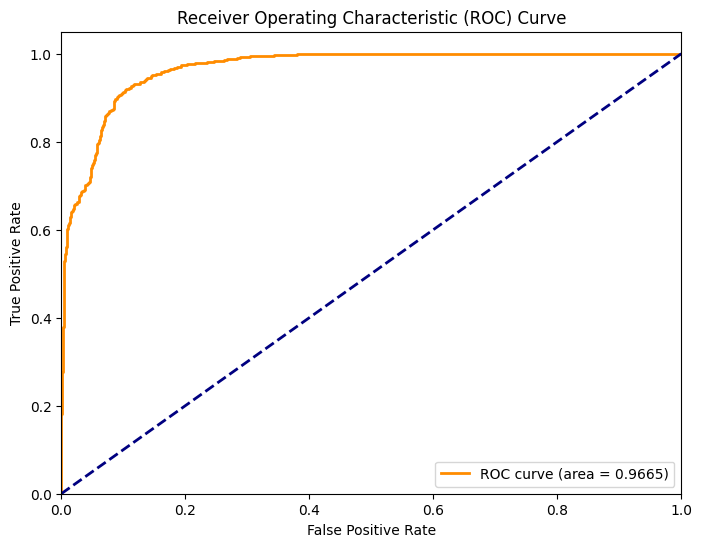

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from sklearn.metrics import roc_curve, auc

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def predict(autoencoder, dataset):
    predictions, losses, targets = [], [], []
    criterion = nn.MSELoss(reduction='mean')  # Replace this with your ReconstructionLoss if needed
    with torch.no_grad():
        autoencoder.eval()

        for input_sequence, target in dataset:
            input_sequence = input_sequence.unsqueeze(0).to(device) 

            seq_pred = autoencoder(input_sequence)
            loss = criterion(seq_pred, input_sequence.squeeze(0)) 
            
            predictions.append(seq_pred.cpu().numpy().flatten())
            losses.append(loss.item())
            targets.append(target.item())
    return predictions, losses, targets

def plot_roc_auc(dataset, autoencoder):
    _, losses, targets = predict(autoencoder, dataset)

    # Convert to numpy arrays for sklearn
    losses = np.array(losses)
    targets = np.array(targets)

    # Compute ROC curve and ROC area
    fpr, tpr, _ = roc_curve(targets, losses)
    roc_auc = auc(fpr, tpr)

    # Plotting
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()

# Assuming validsdatasetVAE is your dataset of sequences
plot_roc_auc(validsdatasetVAE, autoencoder)


In [ ]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
import numpy as np
import torch
import torch.nn as nn
from tqdm import tqdm

def calculate_metrics(dataset, autoencoder, threshold):
    predictions = []
    true_labels = []

    criterion = rae_model.ReconstructionLoss()

    with torch.no_grad():
        autoencoder.eval()
        for input_sequence, target in dataset:
            input_sequence = input_sequence.unsqueeze(0)
            target = target.item()
            true_labels.append(target)
            seq_pred = autoencoder(input_sequence)
            loss = criterion(input_sequence.squeeze(0), seq_pred)

            predictions.append(1 if loss > threshold else 0)

    true_labels = np.array(true_labels)
    predictions = np.array(predictions)

    conf_matrix = confusion_matrix(true_labels, predictions)

    precision = precision_score(true_labels, predictions)
    recall = recall_score(true_labels, predictions)
    f1 = f1_score(true_labels, predictions)

    return conf_matrix, precision, recall, f1

def find_best_threshold(dataset, autoencoder):
    thresholds = np.arange(0, 0.5, 0.01)  
    best_threshold = None
    best_f1 = -1
    results = []

    progress_bar = tqdm(thresholds, desc='Finding Best Threshold', leave=True)
    
    for threshold in progress_bar:
        _, precision, recall, f1 = calculate_metrics(dataset, autoencoder, threshold)
        
        if f1 > best_f1:
            best_f1 = f1
            best_threshold = threshold
        
        progress_bar.set_postfix({'Best F1': best_f1, 'Current Threshold': threshold})
        
        results.append([threshold, precision, recall, f1])
    
    progress_bar.close()

    return best_threshold, best_f1, results

best_threshold, best_f1, threshold_results = find_best_threshold(validsdatasetVAE, autoencoder)
print(f"Best Threshold: {best_threshold:.2f}")
print(f"Best F1 Score: {best_f1:.4f}")

# Print threshold search results as table
print("\nThreshold Search Results:")
print("\nThreshold\tPrecision\tRecall\t\tF1 Score")
for result in threshold_results:
    print(f"{result[0]:.2f}\t\t{result[1]:.4f}\t\t{result[2]:.4f}\t\t{result[3]:.4f}")


Finding Best Threshold:   0%|          | 0/50 [00:00<?, ?it/s]

Finding Best Threshold: 100%|██████████| 50/50 [38:40<00:00, 46.41s/it, Best F1=0.933, Current Threshold=0.49]

Best Threshold: 0.06
Best F1 Score: 0.9332

Threshold Search Results:

Threshold	Precision	Recall		F1 Score
0.00		0.7231		1.0000		0.8393
0.01		0.7239		1.0000		0.8398
0.02		0.7608		1.0000		0.8641
0.03		0.8210		0.9976		0.9007
0.04		0.8628		0.9857		0.9202
0.05		0.8965		0.9715		0.9325
0.06		0.9277		0.9387		0.9332
0.07		0.9472		0.8950		0.9204
0.08		0.9571		0.8475		0.8990
0.09		0.9684		0.8143		0.8846
0.10		0.9737		0.7739		0.8624
0.11		0.9754		0.7335		0.8373
0.12		0.9780		0.6979		0.8145
0.13		0.9816		0.6599		0.7892
0.14		0.9845		0.6352		0.7722
0.15		0.9855		0.6147		0.7572
0.16		0.9857		0.5895		0.7378
0.17		0.9893		0.5715		0.7245
0.18		0.9915		0.5511		0.7084
0.19		0.9913		0.5411		0.7001
0.20		0.9911		0.5316		0.6920
0.21		0.9919		0.5207		0.6829
0.22		0.9916		0.5064		0.6704
0.23		0.9915		0.4974		0.6624
0.24		0.9922		0.4855		0.6520
0.25		0.9921		0.4751		0.6425
0.26		0.9919		0.4660		0.6341
0.27		0.9938		0.4575		0.6265
0.28		0.9937		0.4527		0.6221
0.29		0.9947		0.4437		0.6137
0.30		0.9946		0.4342		

0.031
Precision: 0.9069
Recall: 0.9853
F1 Score: 0.9444


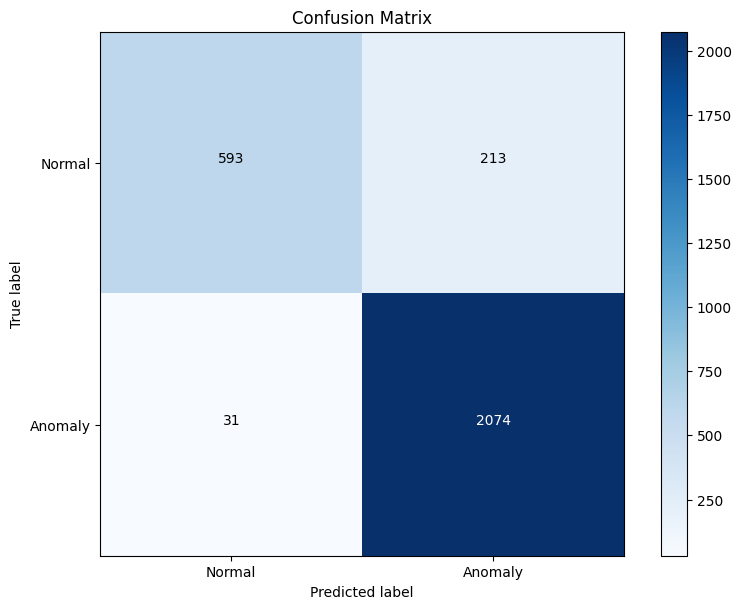

In [9]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
import itertools
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

def calculate_metrics(dataset, autoencoder, threshold):
    predictions = []
    losses = []
    true_labels = []

    criterion = rae_model.ReconstructionLoss()

    with torch.no_grad():
        autoencoder.eval()
        for input_sequence, target in dataset:
            input_sequence = input_sequence.unsqueeze(0)
            target = target.item()
            true_labels.append(target)
            seq_pred = autoencoder(input_sequence)
            loss = criterion(input_sequence.squeeze(0), seq_pred)

            losses.append(loss.item())
            predictions.append(1 if loss > threshold else 0)

    true_labels = np.array(true_labels)
    predictions = np.array(predictions)

    # Compute confusion matrix
    conf_matrix = confusion_matrix(true_labels, predictions)

    # Compute precision, recall, and F1 score
    precision = precision_score(true_labels, predictions)
    recall = recall_score(true_labels, predictions)
    f1 = f1_score(true_labels, predictions)

    return conf_matrix, precision, recall, f1

# Calculate mean and standard deviation of normal heart sample reconstruction losses
def calculate_threshold(dataset, autoencoder):
    normal_losses = []
    criterion = rae_model.ReconstructionLoss()

    with torch.no_grad():
        autoencoder.eval()
        for input_sequence, target in dataset:
            input_sequence = input_sequence.unsqueeze(0)
            target = target.item()
            if target == 0:  
                seq_pred = autoencoder(input_sequence)
                loss = criterion(input_sequence.squeeze(0), seq_pred)
                normal_losses.append(loss.item())

    mean_loss = np.mean(normal_losses)
    std_loss = np.std(normal_losses)
    threshold = 0.03
    # threshold = std_loss  # standard deviation
    print(threshold)
    return threshold

# Plot confusion matrix
def plot_confusion_matrix(conf_matrix):
    plt.figure(figsize=(8, 6))
    plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.get_cmap('Blues'))
    plt.title('Confusion Matrix')
    plt.colorbar()

    classes = ['Normal', 'Anomaly']
    tick_marks = np.arange(len(classes))

    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    thresh = conf_matrix.max() / 2.
    for i, j in itertools.product(range(conf_matrix.shape[0]), range(conf_matrix.shape[1])):
        plt.text(j, i, format(conf_matrix[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if conf_matrix[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

threshold = calculate_threshold(validsdatasetVAE, autoencoder)
conf_matrix, precision, recall, f1 = calculate_metrics(validsdatasetVAE, autoencoder, threshold)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

plot_confusion_matrix(conf_matrix)

plt.show()

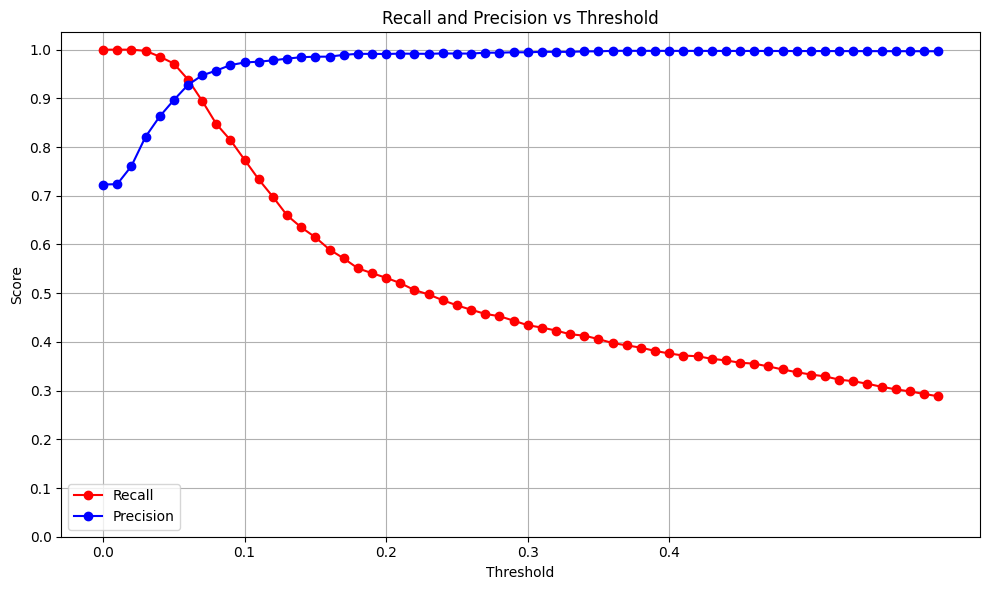

In [ ]:
import random
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn

def predict(autoencoder, dataset):
    predictions, losses = [], []
    criterion = rae_model.ReconstructionLoss()
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    with torch.no_grad():
        autoencoder.eval()

        for input_sequence, target in dataset:
            input_sequence = input_sequence.unsqueeze(0).to(device)
            seq_pred = autoencoder(input_sequence)
            loss = criterion(seq_pred, input_sequence.squeeze(0))
            
            predictions.append(seq_pred.cpu().numpy().flatten())
            losses.append(loss.item()) 
            
    return predictions, losses

def calculate_recall_and_precision(dataset, autoencoder):
    predictions, losses = predict(autoencoder, dataset)
    thresholds = np.arange(0, 0.6, 0.01)
    recall = []
    precision = []
    
    for threshold in thresholds:
        true_positive = 0
        total_true_anomalies = 0
        total_predicted_positives = 0
        
        for pred, loss, (_, target) in zip(predictions, losses, dataset):
            actual = target.item()

            if actual == 1:
                total_true_anomalies += 1

                if loss > threshold:
                    true_positive += 1

        # Count total predicted positives (samples with reconstruction loss > threshold)
        total_predicted_positives = sum(1 for l in losses if l > threshold)

        # Calculate precision and recall for the current threshold
        if total_true_anomalies == 0:
            recall.append(0)
        else:
            recall.append(true_positive / total_true_anomalies)

        if total_predicted_positives == 0:
            precision.append(0)
        else:
            precision.append(true_positive / total_predicted_positives)
    
    return recall, precision, thresholds

def plot_recall_and_precision(recall, precision, thresholds):
    plt.figure(figsize=(10, 6))
    plt.plot(thresholds, recall, marker='o', linestyle='-', color='r', label='Recall')
    plt.plot(thresholds, precision, marker='o', linestyle='-', color='b', label='Precision')
    plt.xlabel('Threshold')
    plt.ylabel('Score')
    plt.title('Recall and Precision vs Threshold')
    plt.xticks(np.arange(0, 0.5, 0.1))
    plt.yticks(np.arange(0, 1.1, 0.1))
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

recall, precision, thresholds = calculate_recall_and_precision(validsdatasetVAE, autoencoder)
plot_recall_and_precision(recall, precision, thresholds)


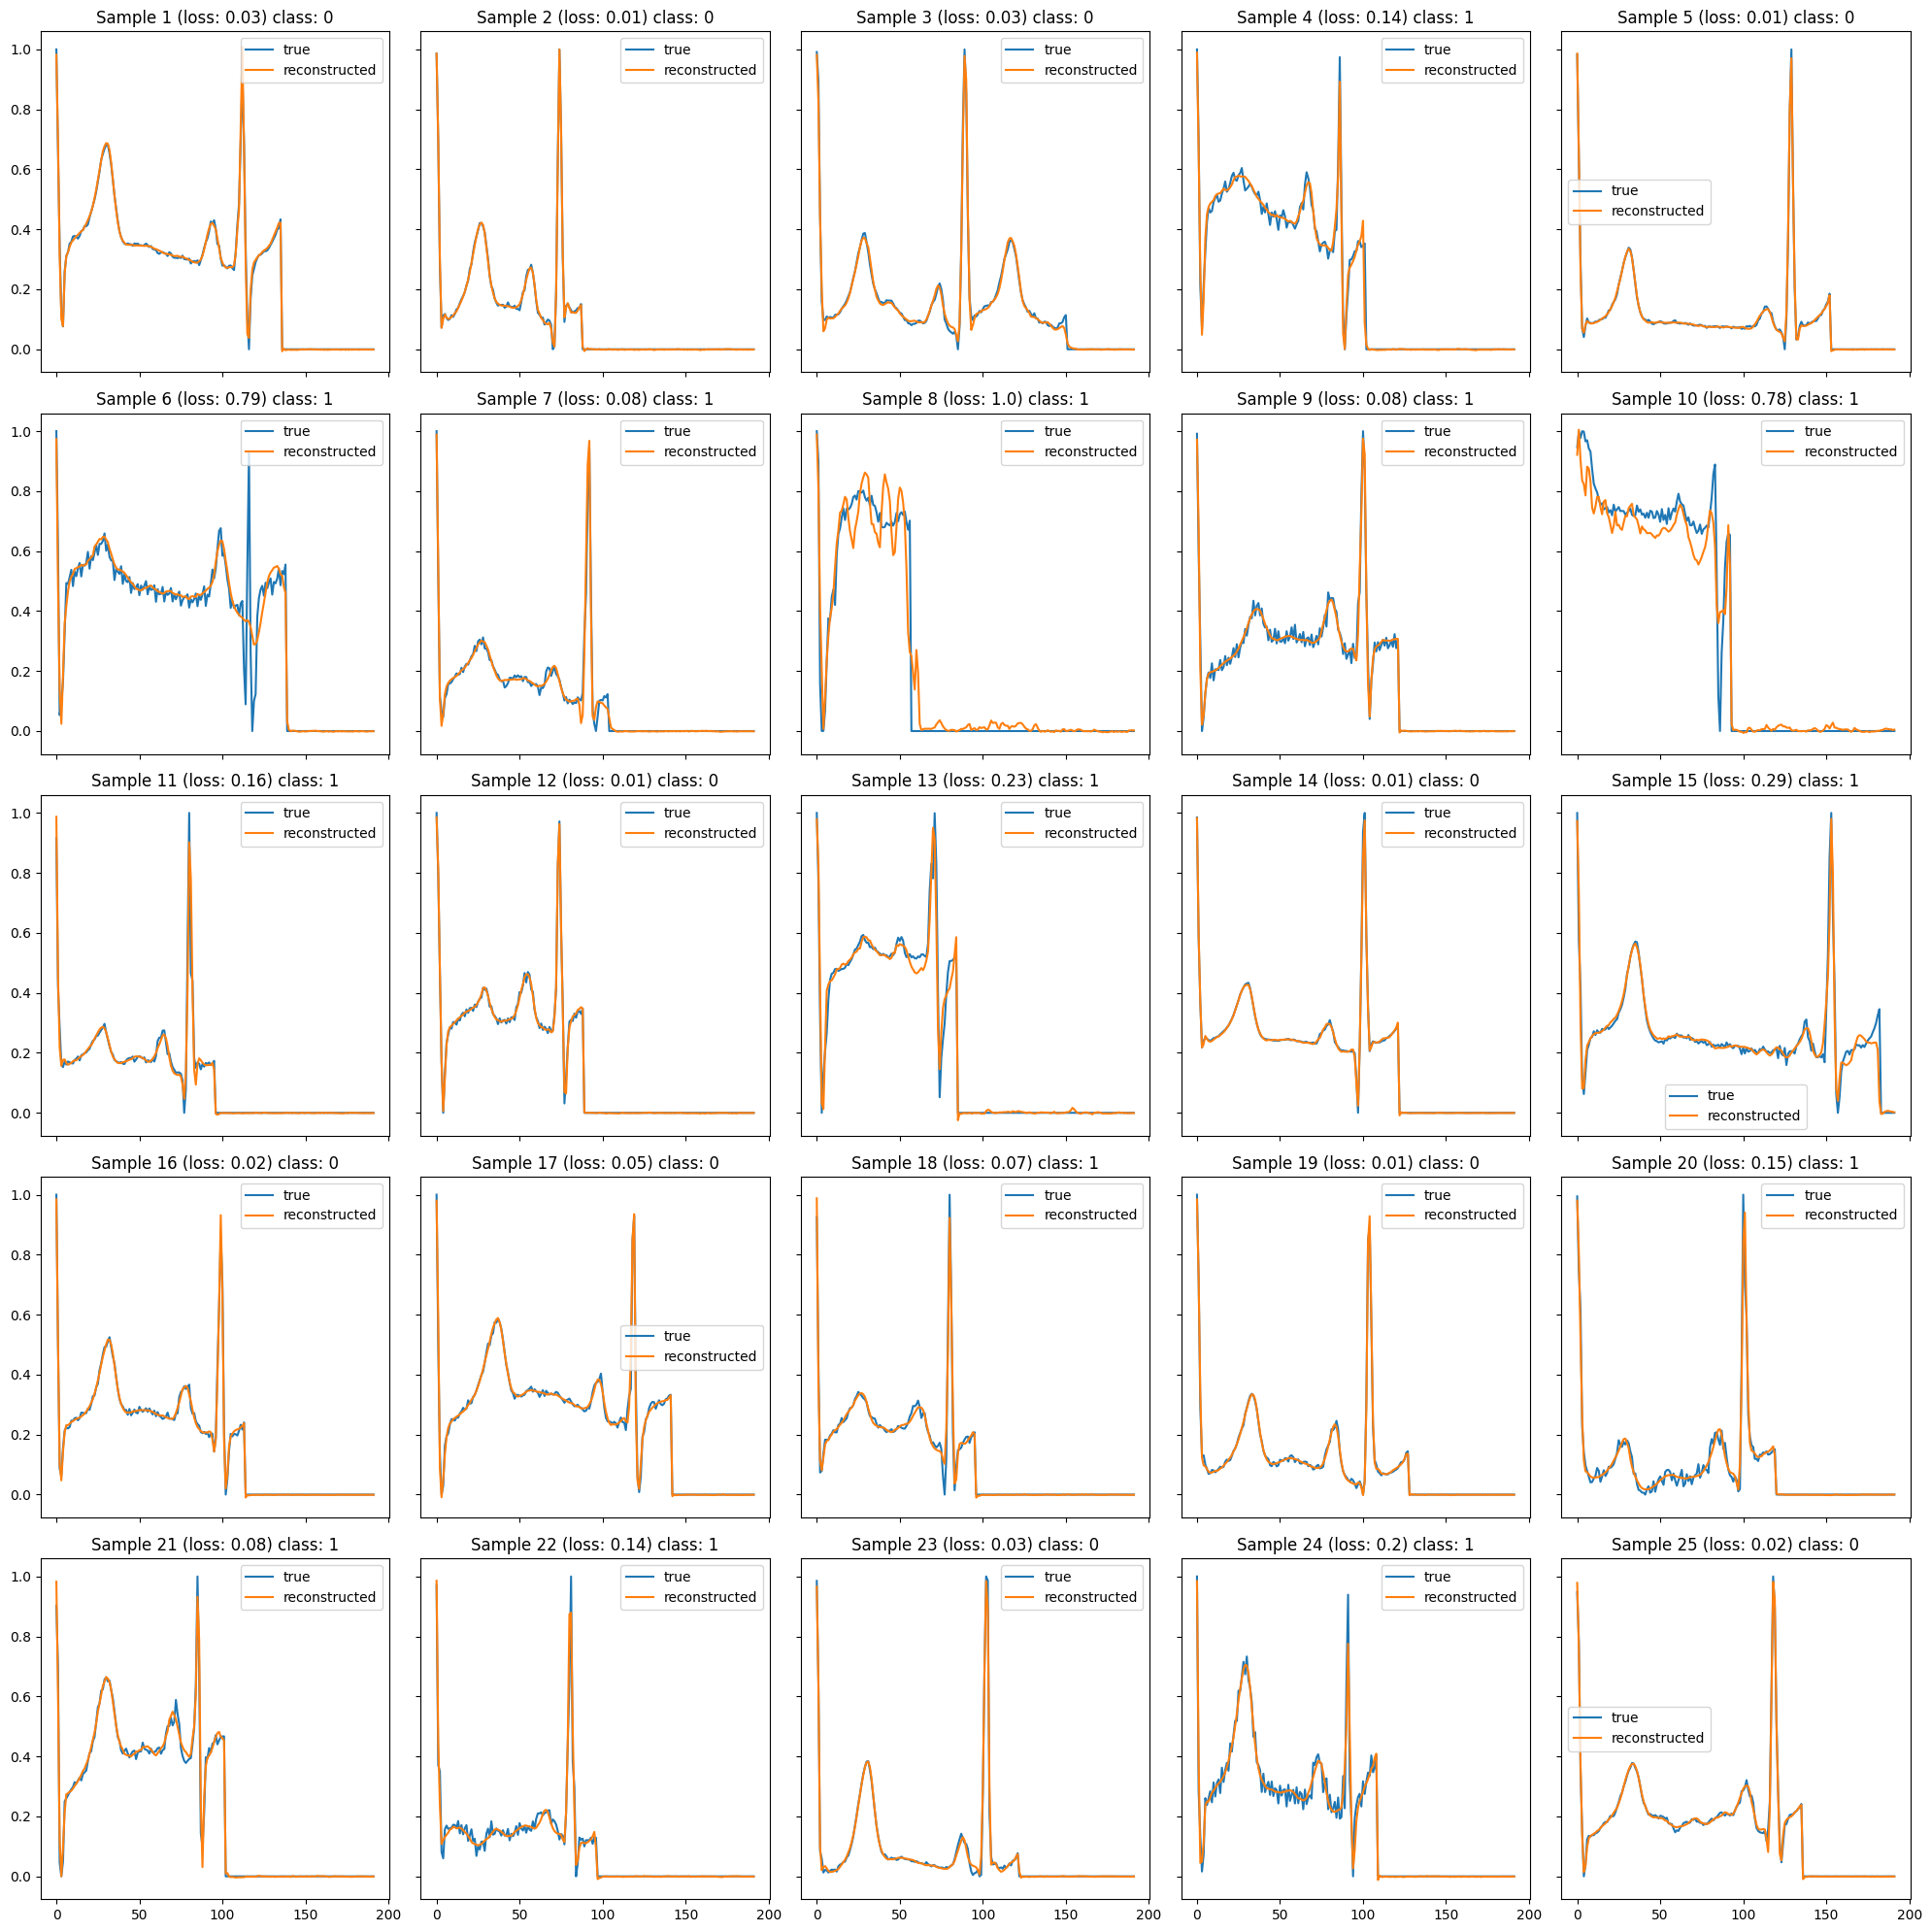

In [12]:
import random
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def predict(autoencoder, dataset):
    predictions, losses = [], []
    criterion = rae_model.ReconstructionLoss()
    with torch.no_grad():
        autoencoder.eval()
        for input_sequence, target in dataset:
            # Ensure input_sequence has correct dimensions (batch_size, seq_len, n_features)
            input_sequence = input_sequence.unsqueeze(0).to(device)  # Add a dummy batch dimension

            seq_pred = autoencoder(input_sequence)
            loss = criterion(seq_pred, input_sequence.squeeze(0))  # Use input_sequence for calculating loss
            
            predictions.append(seq_pred.cpu().numpy().flatten())
            losses.append(loss.item())
    return predictions, losses

def plot_prediction(data, autoencoder, title, ax):
    predictions, pred_losses = predict(autoencoder, [data])  # Pass encoder, decoder, and dataset
    
    input_sequence, target = data  # Extract input_sequence from the tuple
    data_np = input_sequence.cpu().numpy().flatten()  # Convert to NumPy array and flatten
    predictions_np = predictions[0].flatten()  # Flatten predictions
    
    ax.plot(data_np, label='true')
    ax.plot(predictions_np, label='reconstructed')
    ax.set_title(f'{title} (loss: {np.around(pred_losses[0], 2)}) class: {target.item()}')
    ax.legend()

# Assuming validsdatasetVAE is your dataset of sequences
fig, axs = plt.subplots(
    nrows=5,  # 5 rows of plots
    ncols=5,  # 5 columns of plots
    sharey=True,
    sharex=True,
    figsize=(20, 20)  # Larger figure size for better readability
)

num_samples = 25  # Total number of samples to plot
random_indices = random.sample(range(len(validsdatasetVAE)), num_samples)

# Collect the samples
samples = [validsdatasetVAE[idx] for idx in random_indices]

for i, data in enumerate(samples):
    plot_prediction(data, autoencoder, title=f'Sample {i+1}', ax=axs[i // 5, i % 5])  # Pass encoder and decoder
  
fig.tight_layout()
plt.show()
